<h1>Notebook to plot some cluster-cluster results</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
basedir = '/Users/joewandy/git/metabolomics_tools'
sys.path.append(basedir)

In [3]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.stats import ttest_rel

import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

import cPickle
import random
import copy
import glob
import gzip
import string

In [4]:
from alignment.models import HyperPars as AlignmentHyperPars
from alignment.experiment import *
from efcompute.ef_assigner import ef_assigner

In [5]:
hp = AlignmentHyperPars()    
hp.within_file_mass_tol = 5
hp.within_file_rt_tol = 30
hp.across_file_mass_tol = 10
hp.across_file_rt_tol = 60
hp.alpha_mass = 1.0
hp.dp_alpha = 1000.0
hp.beta = 0.1
hp.t = 0.0
hp.mass_clustering_n_iterations = 5000
hp.rt_clustering_nsamps = 500
hp.rt_clustering_burnin = 0

print hp

Hyperparameters across_file_mass_tol=10, across_file_rt_tol=60, alpha_mass=1.0, beta=0.1, dp_alpha=1000.0, mass_clustering_n_iterations=5000, matching_alpha=0.3, rt_clustering_burnin=0, rt_clustering_nsamps=500, second_stage_clustering_use_adduct_likelihood=True, second_stage_clustering_use_mass_likelihood=True, second_stage_clustering_use_rt_likelihood=True, t=0.0, within_file_mass_tol=5, within_file_rt_tol=30


<h2>1. Load the data</h2>

In [6]:
gt_file = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old/ground_truth/ground_truth.txt'
n_set = 5
n = 0

c = string.lowercase[n]
filename = 'pickles/cc_4%s.p' % c
aligner = load_clustering(filename)

c = string.lowercase[n]
filename = 'pickles/cc_no_adduct_4%s.p' % c
aligner_no_adduct = load_clustering(filename)

Loaded from pickles/cc_4a.p
Loaded from pickles/cc_no_adduct_4a.p


In [7]:
print [f.filename for f in aligner.data_list]

['std1-file5.txt', 'std1-file10.txt', 'std1-file6.txt', 'std1-file2.txt']


<h2>2. Plotting Methods</h2>

In [8]:
def find_in_alignment_results(alignment_results, to_search):
    for item, prob in alignment_results:
        # ps_keys = frozenset([f._get_key() for f in item])
        ps_keys = [f._get_key() for f in item]
        if to_search in ps_keys:
            print prob
            for f in item:
                print '- %s' % f

In [9]:
def find_identification(id_rows, mass, rt, intensity):
    EPSILON = 0.0001;
    for f_mass, f_rt, f_intensity, f_iden in id_rows:
        if abs(f_mass - mass) < EPSILON and abs(f_rt - rt) < EPSILON and abs(f_intensity - intensity) < EPSILON:
            return f_iden

In [10]:
def find_diff(a, b, thresh, id_rows):

    a_probs = {}
    b_probs = {}
    key_to_feature = {}
    key_to_id = {}
    
    a_res = []
    for item, p in a:
        aligned = frozenset([f._get_key() for f in item])
        for f in item:
            key_to_feature[f._get_key()] = f
            key_to_id[f._get_key()] = find_identification(id_rows, f.mass, f.rt, f.intensity)
        a_probs[aligned] = p
        a_res.append(aligned)
    a_res = set(a_res)
    
    b_res = []
    for item, p in b:
        aligned = frozenset([f._get_key() for f in item])
        b_probs[aligned] = p
        b_res.append(aligned)
    b_res = set(b_res)    
    
    for aligned in a_res:
        pa = a_probs[aligned]
        if aligned in b_probs:
            pb = b_probs[aligned]
            if pa-pb > thresh and len(aligned)==4:
                print aligned, pa, pb
                found_g = None
                for a in aligned:
                    print "%s identification=%s" % (key_to_feature[a], key_to_id[a])
                    for g in ground_truth:
                        if a in g:
                            found_g = g
                if found_g is not None:
                    print "GT %s" % found_g
                print
                
    return key_to_id

In [11]:
def find_cluster_of_peak(to_find, acs, file_idx):

    ac = acs[file_idx]
    clusters_list = ac.clusters
    for cluster in clusters_list:
        for p, trans in cluster.members:
            if p._get_key() == to_find:
                return cluster

In [31]:
def cluster_plot(title, cluster_list, key_to_id, idx_file, outfile):
    
    tick_fs = 36
    n_cluster = len(cluster_list)
    fig, axs = plt.subplots(nrows=n_cluster, ncols=1, figsize=(24,20), sharex=True)
    
    for i in range(len(cluster_list)):
        
        ax = axs[i]
        cluster = cluster_list[i]
        members = []
        possibles = []
        trans = []        
        cluster_id = []
        for peak, poss in cluster.members:
            members.append(peak)
            possibles.append(poss)
            trans.append(poss.transformation)  
            cluster_id.append(cluster.id)
            
        print "CLUSTER {}".format(cluster.id)
        max_intensity = 0
        for p in range(len(members)):
            iden = None
            if members[p]._get_key() in key_to_id:
                iden = key_to_id[members[p]._get_key()]
            print "Peak {} : {},{},{} -> {},{} (p={}), {}".format(members[p]._get_key(), members[p].mass,members[p].rt,members[p].intensity,
                                                possibles[p].transformation.name,
                                                possibles[p].transformed_mass,
                                                possibles[p].prob, 
                                                iden)
            if members[p].intensity > max_intensity:
                max_intensity = members[p].intensity

        for p_ind in range(len(members)):
            p = members[p_ind]
            po = possibles[p_ind]
            cid = cluster_id[p_ind]
            rel_intensity = p.intensity/max_intensity
            ax.set_title('IP Cluster %d, Standard File %d' % (cid, idx_file[i]+1), fontsize=tick_fs*1.5, loc='right') 
            ax.plot((p.mass,p.mass),(0, rel_intensity),'k-', linewidth=4)
            offset = 0.0
            if po.transformation.name in ('M+ACN+H', '2M+H', 'M+NH4'):
                offset = 0.2                
            if po.transformation.name in ('M+NH4'):
                offset = 0.6               
            if po.transformation.name in ('M+H'):
                offset = 0.1               
            label = "%s (%.2f)" % (po.transformation.name, po.prob)                
            ax.annotate(label, (p.mass, rel_intensity),
                        (p.mass, offset+0.2+rel_intensity),
                        arrowprops=dict(arrowstyle='->', lw=4, color='gray'),
                        textcoords='data', size=tick_fs, weight='bold', rotation=0)
            ax.set_ylabel('Rel. intensity', fontsize=tick_fs)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(tick_fs*1.5) 
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(tick_fs*1.25) 
                
    axs[i].set_xlabel('m/z', fontsize=tick_fs*2)
    plt.subplots_adjust(hspace=0.5, top=0.85)
    plt.suptitle(title, fontsize=tick_fs*2)
#     plt.tight_layout()
    plt.savefig(outfile)

<h2>3. Find some interesting aligned peaksets</h2>

In [13]:
import csv
id_rows = []
with open('/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old/ground_truth/identification.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        mz = float(row[0])
        rt = float(row[1])
        intense = float(row[2])
        iden = row[3]
        item = (mz, rt, intense, iden)
        id_rows.append(item)
print len(id_rows)

2605


In [14]:
input_dir = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old'
gt_file = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old/ground_truth/ground_truth.txt'

from discretisation.preprocessing import FileLoader
loader = FileLoader()        
data_list = loader.load_model_input(input_dir, synthetic=True, verbose=False)    
file_list = []
for data in data_list:
    file_list.append(data.filename)

gt = GroundTruth(gt_file, file_list, data_list, verbose=False)

4999 features read from std1-file1.txt
4986 features read from std1-file2.txt
6836 features read from std1-file3.txt
9752 features read from std1-file4.txt
7076 features read from std1-file5.txt
4146 features read from std1-file6.txt
6319 features read from std1-file7.txt
4101 features read from std1-file8.txt
5485 features read from std1-file9.txt
5034 features read from std1-file10.txt
5317 features read from std1-file11.txt


In [15]:
ground_truth = []
for item in gt.gt_features:
    feature_keys = frozenset([f._get_key() for f in item])
    ground_truth.append(feature_keys)    
print len(ground_truth)

304


In [16]:
key_to_id = find_diff(aligner.alignment_results, aligner_no_adduct.alignment_results, 0.4, id_rows)

frozenset([(244, 5), (144, 1), (145, 4), (327, 9)]) 0.82 0.218
id=(244,5) mass=377.1451 rt=464.63 int=601159.94 identification=StdMix1_9;M+H;monoisotopic
id=(144,1) mass=377.1451 rt=468.55 int=960573.94 identification=StdMix1_9;M+H;monoisotopic
id=(145,4) mass=377.1451 rt=463.77 int=1483404.50 identification=StdMix1_9;M+H;monoisotopic
id=(327,9) mass=377.1452 rt=457.23 int=267687.69 identification=StdMix1_9;M+H;monoisotopic
GT frozenset([(205, 8), (343, 10), (238, 7), (144, 1), (162, 0), (132, 3), (244, 5), (133, 2), (145, 4), (327, 9)])

frozenset([(397, 1), (845, 4), (709, 5), (577, 9)]) 0.772 0.25
id=(397,1) mass=246.0662 rt=561.11 int=288341.00 identification=None
id=(845,4) mass=246.0661 rt=575.63 int=138819.84 identification=None
id=(709,5) mass=246.0660 rt=559.60 int=112463.20 identification=None
id=(577,9) mass=246.0662 rt=490.62 int=123871.18 identification=None

frozenset([(81, 5), (43, 1), (10, 4), (81, 9)]) 0.87 0.452
id=(81,5) mass=255.1100 rt=342.45 int=2309139.25 identif

Interesting clusters are: 
- StdMix1_5 Melatonin C13H16N2O2
- StdMix1_9 riboflavin C17H20N4O6
- StdMix1_32 Asparagine C4H8N2O3
- StdMix1_47 Thiamin C12H16N4OS
- StdMix1_56 Thymidine C10H14N2O5
- StdMix1_69 MOPS C7H15NO4S
- StdMix1_77 L-Cysteate C3H7NO5S

In [17]:
file_idx = {
    1: 3, 
    4: 0,
    5: 2,
    9: 1
}
idx_file = {
    3: 1, 
    0: 4,
    2: 5,
    1: 9
}

CLUSTER 2
Peak (3, 4) : 233.128216429,337.536987305,17466296.0 -> M+H,232.120939977 (p=1.0), StdMix1_5;M+H;monoisotopic
Peak (10, 4) : 255.110031265,337.536987305,10090335.0 -> M+Na,232.120810185 (p=0.9945), StdMix1_5;M+Na;monoisotopic
Peak (163, 4) : 487.231328278,338.99899292,1281227.75 -> 2M+Na,232.121053599 (p=1.0), StdMix1_5;2M+Na;monoisotopic
Peak (266, 4) : 465.249512894,337.536987305,721128.0625 -> 2M+H,232.121118221 (p=1.0), StdMix1_5;2M+H;monoisotopic
Peak (2206, 4) : 296.136549495,337.536987305,25124.1621094 -> M+ACN+Na,232.120779313 (p=0.9918), StdMix1_5;M+ACN+Na;monoisotopic
Peak (2493, 4) : 274.15428669,337.536987305,20278.9375 -> M+ACN+H,232.120461136 (p=0.9968), StdMix1_5;M+ACN+H;monoisotopic
CLUSTER 15
Peak (16, 5) : 233.128172547,340.973999023,7520684.5 -> M+H,232.120896095 (p=1.0), StdMix1_5;M+H;monoisotopic
Peak (81, 5) : 255.109966047,342.454986572,2309139.25 -> M+Na,232.120744967 (p=0.5361), StdMix1_5;M+Na;monoisotopic
Peak (306, 5) : 465.249239251,349.839996338,4

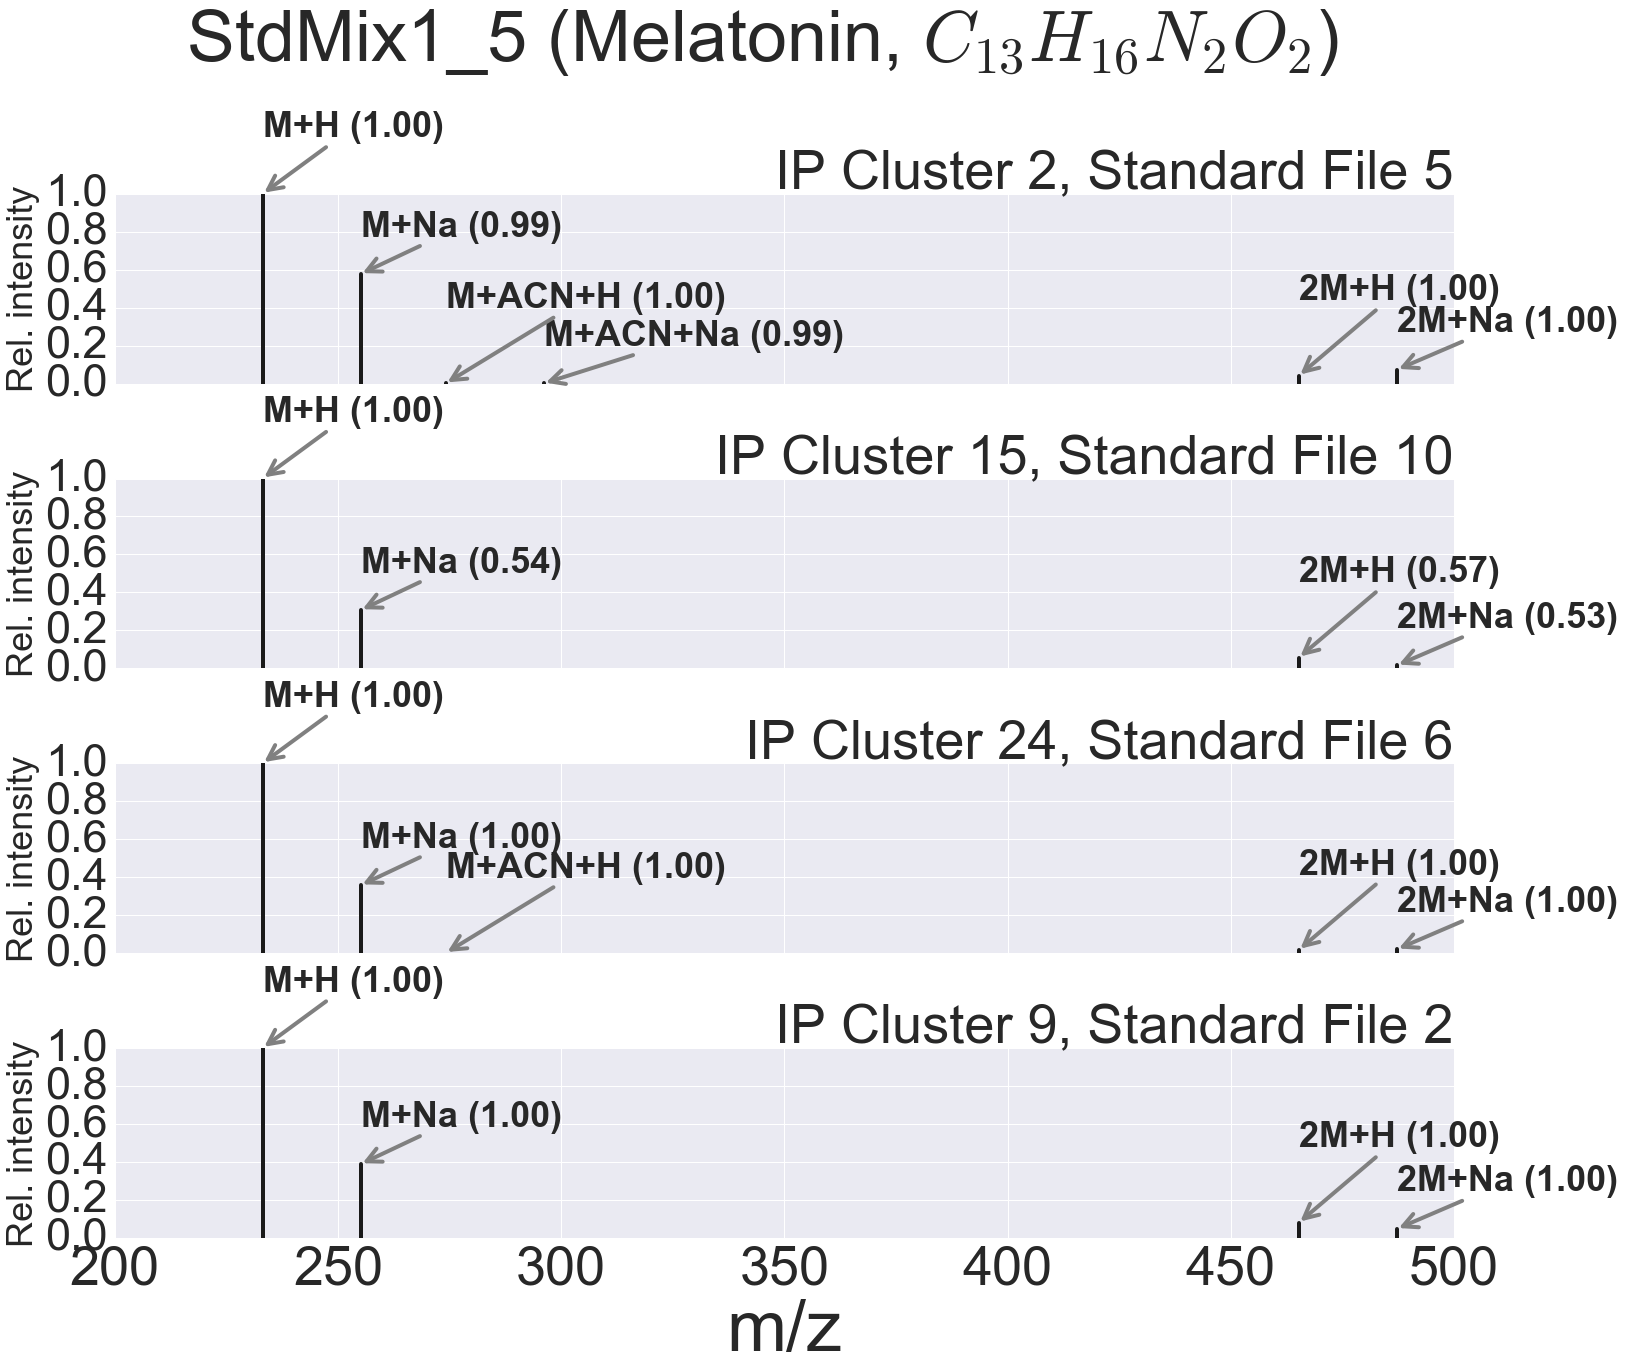

In [32]:
to_find_list = [(3, 4), (16, 5), (25, 9), (10, 1)]
cluster_list = []
for to_find in to_find_list:
    cluster = find_cluster_of_peak(to_find, aligner.clustering_results, file_idx[to_find[1]])
    cluster_list.append(cluster)

title = 'StdMix1_5 (Melatonin, $C_{13}H_{16}N_{2}O_{2}$)'    
cluster_plot(title, cluster_list, key_to_id, idx_file, 'figures/melatonin.pdf')

In [19]:
print sorted([ndl.id for ndl in cluster_list])
print len(aligner.matching_results)
print '----------------------------------------------------------'

counter = dict()
needle = cluster_list[0]
for haystack in aligner.matching_results:
    if needle in haystack:
        peakset = frozenset([h.id for h in haystack])
        if peakset not in counter:
            counter[peakset] = 1
        else:
            counter[peakset] += 1
for key in counter:
    peakset = sorted(list(key))
    c = counter[key]
    print '%-40s%d' % (peakset, c)

[2, 9, 15, 24]
6430047
----------------------------------------------------------
[2, 15, 24]                             14
[2, 9, 15, 47]                          13
[2, 47]                                 6
[2, 9, 15, 24]                          435
[2, 15, 47]                             2
[2, 9, 24]                              10
[2, 24]                                 20


In [20]:
cluster_list_no_adduct = []
for to_find in to_find_list:
    cluster = find_cluster_of_peak(to_find, aligner_no_adduct.clustering_results, file_idx[to_find[1]])
    cluster_list_no_adduct.append(cluster)

In [21]:
print sorted([ndl.id for ndl in cluster_list_no_adduct])
print len(aligner_no_adduct.matching_results)
print '----------------------------------------------------------'

counter = dict()
needle = cluster_list_no_adduct[0]
for haystack in aligner_no_adduct.matching_results:
    if needle in haystack:
        peakset = frozenset([h.id for h in haystack])
        if peakset not in counter:
            counter[peakset] = 1
        else:
            counter[peakset] += 1
for key in counter:
    peakset = sorted(list(key))
    c = counter[key]
    print '%-40s%d' % (peakset, c)

[2, 9, 15, 24]
6581865
----------------------------------------------------------
[2, 9]                                  5
[2, 15, 24]                             26
[2]                                     4
[2, 15]                                 3
[2, 9, 47]                              20
[2, 9, 15, 47]                          100
[2, 9, 15]                              1
[2, 47]                                 34
[2, 9, 15, 24]                          226
[2, 15, 47]                             17
[2, 9, 24]                              34
[2, 24]                                 30


<hr/>

CLUSTER 46
Peak (47, 4) : 170.011513711,1009.0,3997116.75 -> M+H,169.004237259 (p=1.0), StdMix1_77;M+H;monoisotopic
Peak (207, 4) : 339.01586509,1010.44000244,991850.375 -> 2M+H,169.004294319 (p=1.0), StdMix1_77;2M+H;monoisotopic
Peak (549, 4) : 211.037947417,1009.0,259747.515625 -> M+ACN+H,169.004121863 (p=0.9999), StdMix1_77;M+ACN+H;monoisotopic
Peak (1757, 4) : 187.037954375,1009.0,37857.5390625 -> M+NH4,169.004128821 (p=1.0), StdMix1_77;M+NH4;monoisotopic
Peak (2376, 4) : 191.993320307,1011.88000488,21984.1542969 -> M+Na,169.004099227 (p=0.9048), StdMix1_77;M+Na;monoisotopic
CLUSTER 43
Peak (44, 5) : 170.011581569,1000.22998047,3380173.0 -> M+H,169.004305117 (p=1.0), StdMix1_77;M+H;monoisotopic
Peak (308, 5) : 211.038045084,998.807983398,413584.84375 -> M+ACN+H,169.004219531 (p=0.9999), StdMix1_77;M+ACN+H;monoisotopic
Peak (327, 5) : 339.016007273,1005.92999268,379580.34375 -> 2M+H,169.004365411 (p=1.0), StdMix1_77;2M+H;monoisotopic
Peak (3172, 5) : 191.993357729,1015.90997314,6489

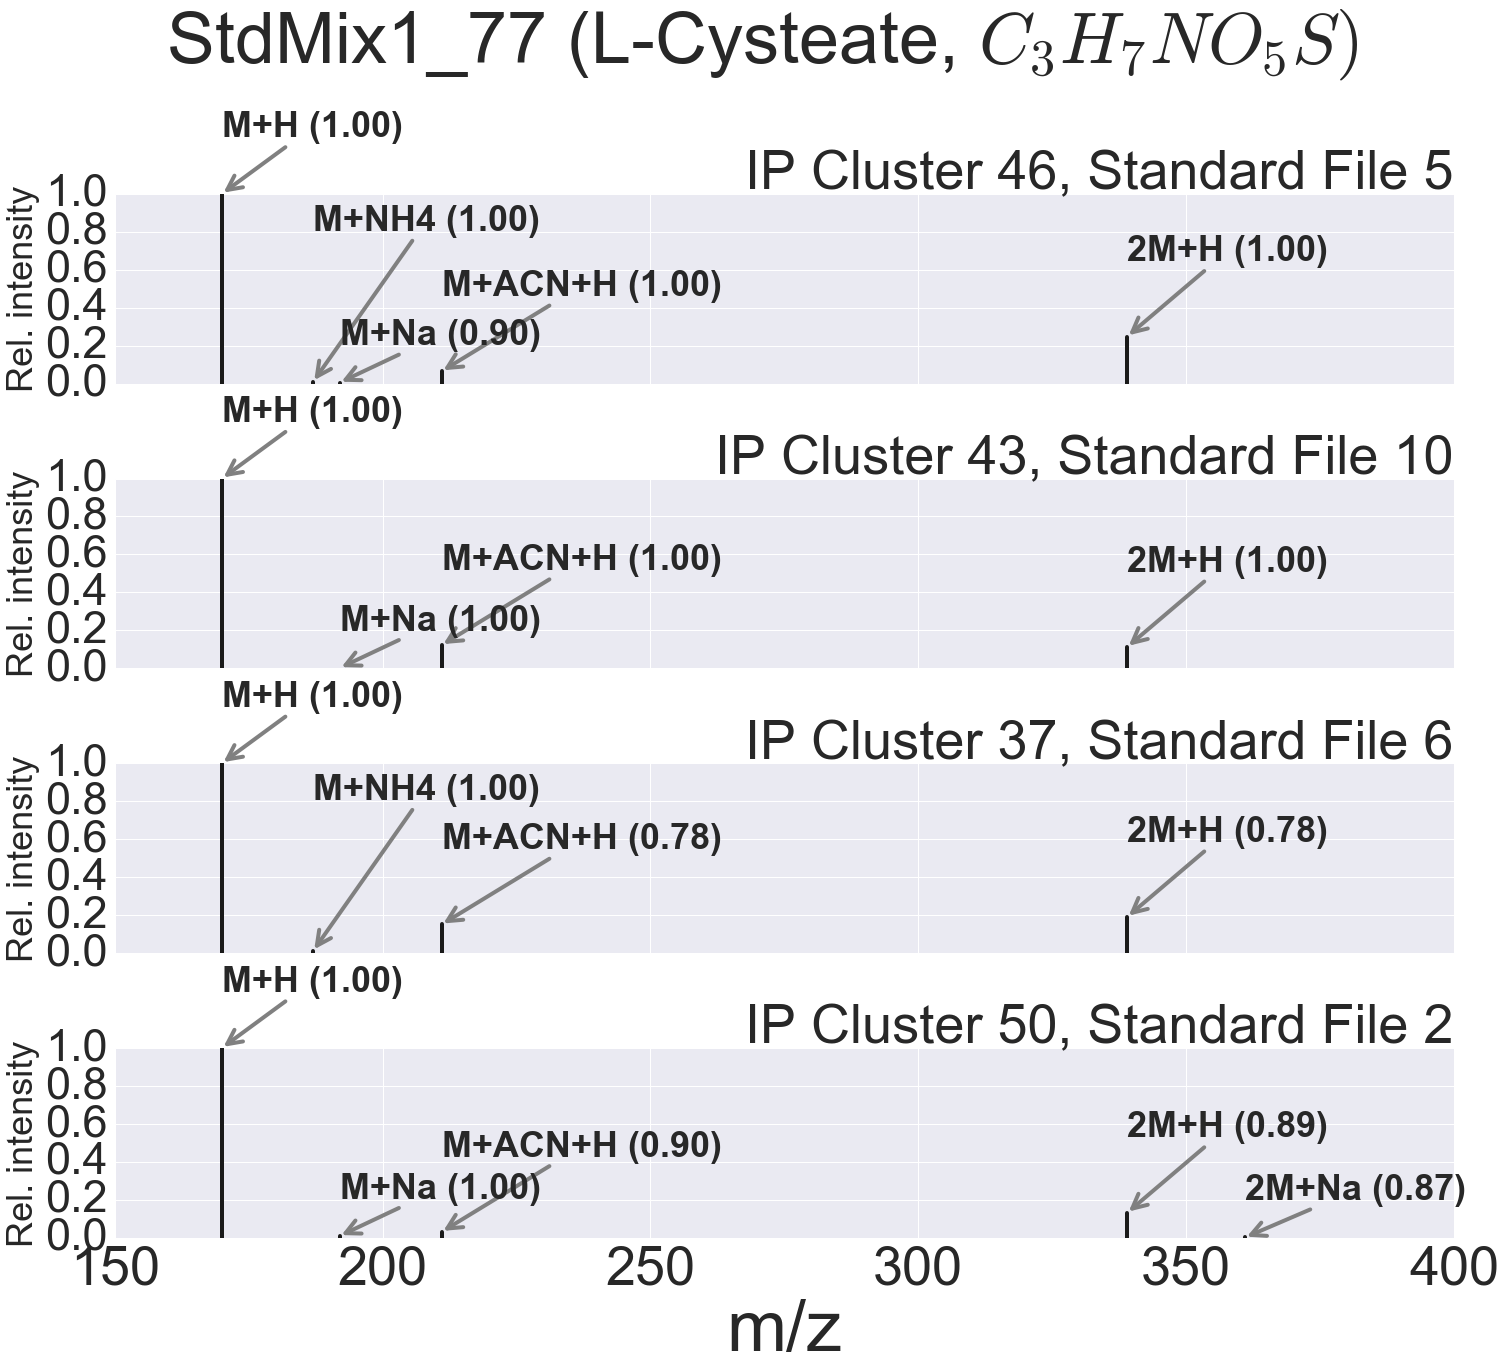

In [33]:
to_find_list = [(47, 4), (44, 5), (38, 9), (51, 1)]
cluster_list = []
for to_find in to_find_list:
    cluster = find_cluster_of_peak(to_find, aligner.clustering_results, file_idx[to_find[1]])
    cluster_list.append(cluster)

title = 'StdMix1_77 (L-Cysteate, $C_{3}H_{7}NO_{5}S)$'
cluster_plot(title, cluster_list, key_to_id, idx_file, 'figures/l_cysteate.pdf')